In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wqw111/vnstock_data/POW/POW_history_1D.csv
/kaggle/input/wqw111/vnstock_data/POW/POW_history_1H.csv
/kaggle/input/wqw111/vnstock_data/POW/POW_history_15m.csv
/kaggle/input/wqw111/vnstock_data/POW/POW_history_5m.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_cash_flow_quarter.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_balance_sheet_year.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_balance_sheet_quarter.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_income_statement_year.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_ratios_quarter.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_cash_flow_year.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_ratios_year.csv
/kaggle/input/wqw111/vnstock_data/POW/financial_reports/POW_income_statement_quarter.csv
/kaggle/input/wqw111/vnstock_data/SHB/SHB_history_5m.csv
/kaggle/input/wqw111/vnstock_data/SHB/SHB_history_15m.

In [2]:
import numpy as np
import pandas as pd
import os
import joblib
import warnings
import math
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# Bỏ qua các cảnh báo (Optional, kept for cleaner output)
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Các hằng số
STOCK_LIST = [
    'ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB',
    'STB', 'TCB', 'TPB', 'VCB', 'VIB'
]
BASE_DATA_DIR = "/kaggle/input/wqw111/vnstock_data"
PRIMARY_TIMEFRAME = '5m'
REQUIRED_OHLCV_COLS = ['open', 'high', 'low', 'close', 'volume']
PREPROCESS_DIR = '/kaggle/working/preprocessed_data'
MODEL_DIR = '/kaggle/working/models'
WINDOW_SIZE = 5
HORIZON = 1
TARGET_COL_NAME = 'close'
USE_ROBUST_SCALER = False

# Tạo các thư mục nếu chúng chưa tồn tại
os.makedirs(PREPROCESS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)





2025-04-21 05:48:11.254238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745214491.547219      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745214491.635008      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Khối 2: Hàm Tải và Làm sạch Dữ liệu Ban đầu

def load_and_initial_clean(symbol):
    """Tải dữ liệu và thực hiện làm sạch cơ bản."""
    file_path = os.path.join(BASE_DATA_DIR, symbol, f"{symbol}_history_{PRIMARY_TIMEFRAME}.csv")
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    df = df[REQUIRED_OHLCV_COLS]

    for col in REQUIRED_OHLCV_COLS:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    initial_rows = len(df)
    df.dropna(subset=REQUIRED_OHLCV_COLS, inplace=True) # Essential dropna
    rows_after_dropna = len(df)
    if initial_rows > rows_after_dropna:
         print(f"[{symbol}] Đã loại bỏ {initial_rows - rows_after_dropna} hàng có NaN trong các cột thiết yếu.")
    return df

print("Đã định nghĩa hàm tải và làm sạch dữ liệu ban đầu.")

# Khối 3: Tải Toàn bộ Dữ liệu & Tạo Đặc trưng Kỹ thuật

df_dict_raw = {}
successful_symbols_load = []
print("Đang tải dữ liệu...")
for symbol in STOCK_LIST:
    try:
        cleaned_df = load_and_initial_clean(symbol)
        if cleaned_df is not None and not cleaned_df.empty:
            df_dict_raw[symbol] = cleaned_df
            successful_symbols_load.append(symbol)
    except FileNotFoundError:
         print(f"Cảnh báo: Không tìm thấy file cho mã {symbol} tại {os.path.join(BASE_DATA_DIR, symbol)}. Bỏ qua.")
    except Exception as e:
         print(f"Lỗi khi tải/làm sạch mã {symbol}: {e}")


STOCK_LIST = successful_symbols_load
print(f"\nĐã tải và làm sạch ban đầu cho {len(STOCK_LIST)} mã cổ phiếu: {STOCK_LIST}")

#Tạo Đặc trưng Kỹ thuật

def add_technical_indicators(df, symbol_name=""):
    """
    Thêm các chỉ báo kỹ thuật tinh tế và nâng cao cho dự báo giá khung 5 phút.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu OHLCV 5 phút.
                           Cần các cột: 'open', 'high', 'low', 'close', 'volume'.
                           Index nên là DateTimeIndex.
        symbol_name (str): Tên mã cổ phiếu (tùy chọn, để in log).

    Returns:
        pd.DataFrame: DataFrame với các đặc trưng kỹ thuật đã được thêm.
    """
    df_with_features = df.copy()

    # Kiểm tra cột đầu vào
    required_cols = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df_with_features.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_with_features.columns]
        raise ValueError(f"[{symbol_name}] DataFrame thiếu các cột bắt buộc: {missing}")

    open_price = df_with_features['open']
    high = df_with_features['high']
    low = df_with_features['low']
    close = df_with_features['close']
    volume = df_with_features['volume'].clip(lower=1e-9) 

    # EMA Ngắn hạn
    df_with_features['ema_5'] = close.ewm(span=5, adjust=False).mean()
    df_with_features['ema_12'] = close.ewm(span=12, adjust=False).mean()
    df_with_features['ema_26'] = close.ewm(span=26, adjust=False).mean()

    # MACD
    df_with_features['macd'] = df_with_features['ema_12'] - df_with_features['ema_26']
    df_with_features['macd_signal'] = df_with_features['macd'].ewm(span=9, adjust=False).mean()
    df_with_features['macd_diff'] = df_with_features['macd'] - df_with_features['macd_signal']

    # RSI (EWM)
    rsi_window = 9
    delta = close.diff()
    gain = delta.where(delta > 0, 0.0).ewm(alpha=1.0/rsi_window, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0.0)).ewm(alpha=1.0/rsi_window, adjust=False).mean()
    loss_safe = loss.replace(0, 1e-9)
    rs = gain / loss_safe
    df_with_features['rsi'] = 100.0 - (100.0 / (1.0 + rs))
    df_with_features['rsi'] = df_with_features['rsi'].fillna(50)

    # ATR (EWM)
    atr_window = 10
    high_low = high - low
    high_close_prev = abs(high - close.shift())
    low_close_prev = abs(low - close.shift())
    ranges = pd.concat([high_low, high_close_prev, low_close_prev], axis=1)
    true_range = ranges.max(axis=1)
    df_with_features['atr'] = true_range.ewm(alpha=1.0/atr_window, adjust=False).mean()

    # Volume EMA
    vol_ema_window = 20
    df_with_features['volume_ema_20'] = volume.ewm(span=vol_ema_window, adjust=False).mean()

    # VWAP (Rolling)
    vwap_window = 20
    tp = (high + low + close) / 3
    vwap_numerator = (tp * volume).rolling(window=vwap_window).sum()
    vwap_denominator = volume.rolling(window=vwap_window).sum().replace(0, 1e-9) # Tránh chia 0
    df_with_features['vwap_roll'] = vwap_numerator / vwap_denominator

    # Volatility (Std Dev of Log Returns)
    vol_window_short = 10
    vol_window_long = 20 
    log_return = np.log(close / close.shift()).fillna(0)
    df_with_features[f'volatility_{vol_window_short}'] = log_return.rolling(window=vol_window_short).std() * np.sqrt(vol_window_short)
    df_with_features[f'volatility_{vol_window_long}'] = log_return.rolling(window=vol_window_long).std() * np.sqrt(vol_window_long)

    # Động lực của Chỉ báo (Indicator Momentum)
    df_with_features['rsi_roc_1'] = df_with_features['rsi'].diff() # RSI thay đổi nhanh thế nào?
    df_with_features['macd_diff_roc_1'] = df_with_features['macd_diff'].diff() # MACD Histogram thay đổi nhanh thế nào?

    # Chuẩn hóa Khoảng cách EMA
    # Khoảng cách giữa EMA nhanh và chậm dưới dạng % của EMA chậm -> đo độ phân kỳ chuẩn hóa
    ema_12_safe = df_with_features['ema_12'].replace(0, np.nan) # Tránh chia cho 0
    df_with_features['ema_5_12_spread_pct'] = (df_with_features['ema_5'] - df_with_features['ema_12']) / ema_12_safe * 100

    # Động lực Biến động (Volatility Dynamics)
    # Tỷ lệ biến động ngắn hạn so với dài hạn (intraday)
    vol_long_safe = df_with_features[f'volatility_{vol_window_long}'].replace(0, np.nan)
    df_with_features['vol_short_long_ratio'] = df_with_features[f'volatility_{vol_window_short}'] / vol_long_safe
    # Tốc độ thay đổi của ATR -> Biến động đang tăng hay giảm?
    df_with_features['atr_roc_1'] = df_with_features['atr'].diff()

    # # Động lực Khối lượng (Volume Dynamics)
    # # Hệ số đột biến Khối lượng (Volume Spike Factor) -> Khối lượng hiện tại gấp mấy lần trung bình?
    # vol_ema_safe = df_with_features['volume_ema_20'].replace(0, np.nan)
    # df_with_features['volume_spike_factor'] = volume / vol_ema_safe
    # # Tương tác Giá-Khối lượng cơ bản (ngoài OBV)
    # df_with_features['price_change_x_volume'] = close.diff() * volume # Thay đổi giá nhân khối lượng
    # df_with_features['log_return_x_volume'] = log_return * volume    # Log return nhân khối lượng

    # Đặc trưng Vi cấu trúc Nến (Candlestick Microstructure)
    df_with_features['candle_body_size'] = abs(close - open_price)
    df_with_features['candle_upper_wick'] = high - np.maximum(open_price, close)
    df_with_features['candle_lower_wick'] = np.minimum(open_price, close) - low
    candle_range = (high - low).replace(0, np.nan) # Tránh chia cho 0
    df_with_features['candle_body_ratio'] = df_with_features['candle_body_size'] / candle_range # Tỷ lệ thân nến / toàn bộ nến

    # Tương tác Giá - VWAP - ATR (Price-VWAP-ATR Interaction)
    # Khoảng cách từ giá đóng cửa đến VWAP tính theo đơn vị ATR -> chuẩn hóa theo biến động
    atr_safe = df_with_features['atr'].replace(0, np.nan)
    df_with_features['price_vwap_dist_atr'] = (close - df_with_features['vwap_roll']) / atr_safe

    # Chỉ báo được làm mượt (Smoothed Indicators)
    # Làm mượt RSI bằng EMA(3) để giảm nhiễu, giữ lại RSI gốc
    df_with_features['rsi_smoothed_3'] = df_with_features['rsi'].ewm(span=3, adjust=False).mean()

    df_with_features.replace([np.inf, -np.inf], np.nan, inplace=True)

    initial_len = len(df_with_features)
    df_with_features.dropna(inplace=True)
    final_len = len(df_with_features)

    rows_dropped = initial_len - final_len
    if rows_dropped > 0:
        print(f"[{symbol_name}] Đã loại bỏ {rows_dropped} hàng đầu tiên do chứa NaN từ việc tính toán các đặc trưng tinh tế.")

    return df_with_features

#  Thêm các chỉ báo vào dữ liệu 
data_with_indicators = {}
successful_symbols_indicators = []
print("\nĐang thêm các chỉ báo kỹ thuật...")
for symbol in STOCK_LIST:
    df_raw = df_dict_raw[symbol] 
    processed_df = add_technical_indicators(df_raw, symbol_name=symbol)
    if not processed_df.empty:
        data_with_indicators[symbol] = processed_df
        successful_symbols_indicators.append(symbol)
    else:
        print(f"Cảnh báo: DataFrame trống cho mã {symbol} sau khi thêm chỉ báo. Bỏ qua.")


STOCK_LIST = successful_symbols_indicators # Update list again
print(f'\nĐã thêm các chỉ báo kỹ thuật. Số mã cổ phiếu có thể sử dụng: {len(STOCK_LIST)}')
if not STOCK_LIST:
    raise SystemExit("Không còn dữ liệu cổ phiếu nào sau khi thêm chỉ báo. Thoát.")


Đã định nghĩa hàm tải và làm sạch dữ liệu ban đầu.
Đang tải dữ liệu...
[ACB] Đã loại bỏ 144628 hàng có NaN trong các cột thiết yếu.
[BID] Đã loại bỏ 144677 hàng có NaN trong các cột thiết yếu.
[CTG] Đã loại bỏ 144619 hàng có NaN trong các cột thiết yếu.
[HDB] Đã loại bỏ 144668 hàng có NaN trong các cột thiết yếu.
[LPB] Đã loại bỏ 144776 hàng có NaN trong các cột thiết yếu.
[MBB] Đã loại bỏ 144596 hàng có NaN trong các cột thiết yếu.
[SHB] Đã loại bỏ 144618 hàng có NaN trong các cột thiết yếu.
[STB] Đã loại bỏ 144601 hàng có NaN trong các cột thiết yếu.
[TCB] Đã loại bỏ 144629 hàng có NaN trong các cột thiết yếu.
[TPB] Đã loại bỏ 144622 hàng có NaN trong các cột thiết yếu.
[VCB] Đã loại bỏ 144677 hàng có NaN trong các cột thiết yếu.
[VIB] Đã loại bỏ 144683 hàng có NaN trong các cột thiết yếu.

Đã tải và làm sạch ban đầu cho 12 mã cổ phiếu: ['ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB', 'STB', 'TCB', 'TPB', 'VCB', 'VIB']

Đang thêm các chỉ báo kỹ thuật...
[ACB] Đã loại bỏ 1292 hàng đầ

In [4]:
# Khối 4: Chia Dữ liệu (Train/Validation/Test)
train_data = {}
val_data = {}
test_data = {}
successful_symbols_split = []
min_data_points_for_split = WINDOW_SIZE + HORIZON + 20 

print("Đang chia dữ liệu...")
for symbol in STOCK_LIST:
    df = data_with_indicators[symbol] 
    n = len(df)

    if n < min_data_points_for_split:
        print(f"Cảnh báo: Bỏ qua mã {symbol} do không đủ điểm dữ liệu ({n} < {min_data_points_for_split}).")
        continue

    # Chia theo tỷ lệ 80% train, 10% val, 10% test
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    train_df = df.iloc[:train_size].copy()
    val_df = df.iloc[train_size : train_size + val_size].copy()
    test_df = df.iloc[train_size + val_size :].copy()

    # Basic check for non-empty splits
    if train_df.empty or val_df.empty or test_df.empty:
         print(f"Cảnh báo: Một trong các tập dữ liệu trống sau khi chia cho mã {symbol}. Bỏ qua.")
         continue

    train_data[symbol] = train_df
    val_data[symbol] = val_df
    test_data[symbol] = test_df
    successful_symbols_split.append(symbol)

STOCK_LIST = successful_symbols_split # Update list again
print(f'\nHoàn tất chia dữ liệu cho {len(STOCK_LIST)} mã cổ phiếu: {STOCK_LIST}')
if not STOCK_LIST:
    raise SystemExit("Không còn dữ liệu cổ phiếu nào sau khi chia tách. Thoát.")



Đang chia dữ liệu...

Hoàn tất chia dữ liệu cho 12 mã cổ phiếu: ['ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB', 'STB', 'TCB', 'TPB', 'VCB', 'VIB']


In [5]:
# Khối 5: Xử lý Missing Value SAU KHI Chia Tách

def apply_ffill(data_dict):
    """Áp dụng forward fill cho các DataFrame."""
    filled_dict = {}
    for symbol, df in data_dict.items():
        df_filled = df.copy()
        initial_nas = df_filled.isna().sum().sum()
        if initial_nas > 0:
            df_filled.ffill(inplace=True)
            remaining_nas = df_filled.isna().sum().sum()
            if remaining_nas > 0:
                df_filled.bfill(inplace=True) # Try backfill
                if df_filled.isna().sum().sum() > 0:
                     print(f"[{symbol}] Cảnh báo: Vẫn còn NaN sau ffill/bfill. Kiểm tra dữ liệu.")
        filled_dict[symbol] = df_filled
    return filled_dict

train_data = apply_ffill(train_data)
val_data = apply_ffill(val_data)
test_data = apply_ffill(test_data)
print("Đã xử lý NaN sau khi chia tách.")



Đã xử lý NaN sau khi chia tách.


In [6]:
# Khối 6: Chuẩn hóa Dữ liệu (Scaling) và Mã hóa One-Hot (Encoding) 
class DataProcessor:
    """Lớp xử lý chuẩn hóa và mã hóa cho dữ liệu (Sử dụng reset_index)."""
    def __init__(self):
        if USE_ROBUST_SCALER:
            self.scaler = RobustScaler()
            print("Sử dụng RobustScaler.")
        else:
            self.scaler = MinMaxScaler(feature_range=(0, 1))
            print("Sử dụng MinMaxScaler.")
        self.encoder = OneHotEncoder(categories=[STOCK_LIST], sparse_output=False, handle_unknown='ignore', dtype=np.float32)
        self.numeric_columns_ = None
        self.encoded_feature_names_ = None
        self.n_features_in_ = None
        self.fitted_ = False
        self.target_col_index_in_numeric_ = -1

    def _prepare_combined_data(self, data_dict):
        """Kết hợp dữ liệu, reset index và trả về index gốc."""
        all_data = []
        original_row_indices = {} 
        current_pos = 0
        valid_symbols_in_dict = [s for s in STOCK_LIST if s in data_dict and not data_dict[s].empty]

        if not valid_symbols_in_dict:
             return pd.DataFrame(), {}, [], pd.Index([])

        for symbol in valid_symbols_in_dict:
            df = data_dict[symbol].copy()
            df['symbol_cat_temp'] = symbol
            all_data.append(df)
            start_row = current_pos
            end_row = current_pos + len(df)
            original_row_indices[symbol] = (start_row, end_row)
            current_pos = end_row

        combined_data = pd.concat(all_data, axis=0, ignore_index=False)
        original_dt_index = combined_data.index
        combined_data.reset_index(drop=True, inplace=True)

        return combined_data, original_row_indices, valid_symbols_in_dict, original_dt_index

    def fit_transform(self, data_dict):
        """Fit scaler, encoder trên train data và biến đổi nó."""
        combined_data, original_row_indices, valid_symbols, original_dt_index = self._prepare_combined_data(data_dict)

        if combined_data.empty:
            print("Cảnh báo: Không có dữ liệu hợp lệ để fit_transform.")
            return {}

        self.numeric_columns_ = combined_data.select_dtypes(include=np.number).columns.tolist()
        if 'symbol_cat_temp' in self.numeric_columns_:
            self.numeric_columns_.remove('symbol_cat_temp')

        self.target_col_index_in_numeric_ = self.numeric_columns_.index(TARGET_COL_NAME)
        numeric_data = combined_data[self.numeric_columns_].values
        scaled_numeric_values = self.scaler.fit_transform(numeric_data)
        self.n_features_in_ = self.scaler.n_features_in_
        scaled_numeric_df = pd.DataFrame(scaled_numeric_values, columns=self.numeric_columns_, index=combined_data.index)

        symbols_array = combined_data[['symbol_cat_temp']]
        self.encoder.fit(pd.DataFrame({'symbol_cat_temp': STOCK_LIST}))
        symbol_encoded_values = self.encoder.transform(symbols_array)
        self.encoded_feature_names_ = self.encoder.get_feature_names_out(['symbol_cat_temp'])
        encoded_df = pd.DataFrame(symbol_encoded_values, columns=self.encoded_feature_names_, index=combined_data.index)

        final_df = pd.concat([scaled_numeric_df, encoded_df], axis=1)

        transformed_dict = {}
        for symbol, (start_row, end_row) in original_row_indices.items():
            symbol_df_processed = final_df.iloc[start_row:end_row].copy()
            symbol_dt_index = original_dt_index[start_row:end_row]
            symbol_df_processed.index = symbol_dt_index
            transformed_dict[symbol] = symbol_df_processed
            # print(f"--- fit_transform: Shape của transformed_dict['{symbol}'] sau khi tách: {transformed_dict[symbol].shape}") # Optional Debug

        joblib.dump(self.scaler, os.path.join(PREPROCESS_DIR, 'feature_scaler.pkl'))
        joblib.dump(self.encoder, os.path.join(PREPROCESS_DIR, 'symbol_encoder.pkl'))
        joblib.dump(self.numeric_columns_, os.path.join(PREPROCESS_DIR, 'numeric_columns.pkl'))
        joblib.dump(self.encoded_feature_names_, os.path.join(PREPROCESS_DIR, 'encoded_feature_names.pkl'))
        joblib.dump(self.target_col_index_in_numeric_, os.path.join(PREPROCESS_DIR, 'target_col_index.pkl'))
        self.fitted_ = True
        print("Đã fit và lưu Scaler, Encoder, và thông tin cột.")
        return transformed_dict

    def transform(self, data_dict):
        """Transform dữ liệu val/test dùng scaler và encoder đã fit."""
        if not self.fitted_:
            self.scaler = joblib.load(os.path.join(PREPROCESS_DIR, 'feature_scaler.pkl'))
            self.encoder = joblib.load(os.path.join(PREPROCESS_DIR, 'symbol_encoder.pkl'))
            self.numeric_columns_ = joblib.load(os.path.join(PREPROCESS_DIR, 'numeric_columns.pkl'))
            self.encoded_feature_names_ = joblib.load(os.path.join(PREPROCESS_DIR, 'encoded_feature_names.pkl'))
            self.target_col_index_in_numeric_ = joblib.load(os.path.join(PREPROCESS_DIR, 'target_col_index.pkl'))
            self.n_features_in_ = self.scaler.n_features_in_
            self.fitted_ = True

        combined_data, original_row_indices, valid_symbols, original_dt_index = self._prepare_combined_data(data_dict)

        if combined_data.empty:
            print("Cảnh báo: Không có dữ liệu hợp lệ để transform.")
            return {}


        numeric_data = combined_data[self.numeric_columns_].values
        scaled_numeric_values = self.scaler.transform(numeric_data) # Only transform
        scaled_numeric_df = pd.DataFrame(scaled_numeric_values, columns=self.numeric_columns_, index=combined_data.index)

        symbols_array = combined_data[['symbol_cat_temp']]
        symbol_encoded_values = self.encoder.transform(symbols_array) # Only transform
        encoded_df = pd.DataFrame(symbol_encoded_values, columns=self.encoded_feature_names_, index=combined_data.index)

        final_df = pd.concat([scaled_numeric_df, encoded_df], axis=1)
        # print(f"Shape của đặc trưng kết hợp sau khi transform: {final_df.shape}") # Optional

        transformed_dict = {}
        for symbol, (start_row, end_row) in original_row_indices.items():
            symbol_df_processed = final_df.iloc[start_row:end_row].copy()
            symbol_dt_index = original_dt_index[start_row:end_row]
            symbol_df_processed.index = symbol_dt_index
            transformed_dict[symbol] = symbol_df_processed

        return transformed_dict

    def inverse_transform_target(self, scaled_target_values):
        """Chuyển đổi ngược giá trị của cột target về thang đo gốc."""
        num_scaler_features = self.n_features_in_
        scaled_values_flat = np.array(scaled_target_values).flatten()
        dummy_array = np.zeros((len(scaled_values_flat), num_scaler_features))
        dummy_array[:, self.target_col_index_in_numeric_] = scaled_values_flat
        inversed_array = self.scaler.inverse_transform(dummy_array)
        return inversed_array[:, self.target_col_index_in_numeric_]

# Xử lý Dữ liệu
data_processor = DataProcessor()
scaled_encoded_train_data = None
scaled_encoded_val_data = None
scaled_encoded_test_data = None
sequence_feature_names = []

print("\nĐang fit và transform dữ liệu training...")
scaled_encoded_train_data = data_processor.fit_transform(train_data)

if not scaled_encoded_train_data:
     raise SystemExit("Lỗi: Dữ liệu training trống sau khi xử lý. Thoát.")

# Lấy danh sách tên features cuối cùng
example_symbol = next(iter(scaled_encoded_train_data))
sequence_feature_names = scaled_encoded_train_data[example_symbol].columns.tolist()

print("\nĐang transform dữ liệu validation...")
scaled_encoded_val_data = data_processor.transform(val_data)
print("\nĐang transform dữ liệu test...")
scaled_encoded_test_data = data_processor.transform(test_data)

print('\nHoàn tất chuẩn hóa (scaling) và mã hóa (encoding) dữ liệu.')
print(f"Tổng số features cho mô hình sequence: {len(sequence_feature_names)}")




Sử dụng MinMaxScaler.

Đang fit và transform dữ liệu training...
Đã fit và lưu Scaler, Encoder, và thông tin cột.

Đang transform dữ liệu validation...

Đang transform dữ liệu test...

Hoàn tất chuẩn hóa (scaling) và mã hóa (encoding) dữ liệu.
Tổng số features cho mô hình sequence: 40


In [7]:
# Khối 7: Hàm Vẽ Biểu Đồ Chung và Hàm Đánh Giá
def plot_predictions(y_true, y_pred, title, plot_limit=200):
    """Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán."""
    plt.figure(figsize=(14, 7))
    limit = min(plot_limit, len(y_true), len(y_pred))
    plt.plot(y_true[:limit], label='Giá thực tế', color='blue', marker='.', linestyle='-', markersize=3)
    plt.plot(y_pred[:limit], label='Giá dự đoán', color='red', marker='x', linestyle='--', markersize=3)
    plt.title(f'{title} ({limit} điểm đầu tiên)')
    plt.ylabel('Giá (Thang đo gốc)')
    plt.xlabel('Bước thời gian (Tập Test)')
    plt.legend()
    plt.grid(True)
    # plt.show() # Consider showing plots at the end or saving them instead
    plt.show(block=False) # Show non-blocking
    plt.pause(1) # Pause to allow plot to render
    plt.close() # Close the plot window


def evaluate_model(y_true, y_pred, model_name, symbol="Overall"):
    """Tính toán và in các metrics đánh giá."""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"[{model_name} - {symbol}] Dữ liệu trống, không thể đánh giá.")
        return {'r2': np.nan, 'mse': np.nan, 'mae': np.nan}

    if len(y_true) != len(y_pred):
        print(f"[{model_name} - {symbol}] Cảnh báo: Độ dài y_true ({len(y_true)}) và y_pred ({len(y_pred)}) không khớp. Cắt về {min(len(y_true), len(y_pred))}.")
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        if min_len == 0: return {'r2': np.nan, 'mse': np.nan, 'mae': np.nan}

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Kết quả Đánh giá {model_name} cho [{symbol}] (Thang đo gốc): R2={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")
    return {'r2': r2, 'mse': mse, 'mae': mae}

print("Đã định nghĩa hàm vẽ biểu đồ và hàm đánh giá.")


# Khối 8: Định nghĩa Lớp Data Generator cho Dữ liệu Phẳng (Flattened) - Cho SGD

class StockDataSequenceFlattened(Sequence):
    """Lớp tạo batch dữ liệu ĐÃ LÀM PHẲNG cho Keras Sequence"""
    def __init__(self, data_dict, window_size, horizon, batch_size,
                 target_col_name='close', feature_list=None, shuffle=True):
        self.data_dict = data_dict
        self.window_size = window_size
        self.horizon = horizon
        self.batch_size = batch_size
        self.target_col_name = target_col_name
        self.shuffle = shuffle
        self.feature_list = feature_list

        self.stock_data_arrays = {symbol: df.values for symbol, df in self.data_dict.items() if not df.empty}
        self.valid_symbols = list(self.stock_data_arrays.keys())

        if not self.feature_list:
            if not self.valid_symbols: raise ValueError("Data dictionary trống khi khởi tạo generator phẳng.")
            first_symbol = self.valid_symbols[0]
            self.feature_list = self.data_dict[first_symbol].columns.tolist()

        self.target_col_index_in_features = self.feature_list.index(self.target_col_name)

        self.indices = []
        for symbol in self.valid_symbols:
            n_samples = len(self.stock_data_arrays[symbol])
            last_valid_start_index = n_samples - self.window_size - self.horizon
            if last_valid_start_index >= 0:
                for i in range(last_valid_start_index + 1):
                    self.indices.append((symbol, i))

        if not self.indices and self.valid_symbols: # Only warn if there should be indices
             print(f"Cảnh báo: Không tạo được index hợp lệ nào cho generator phẳng (Symbols: {self.valid_symbols}). Kiểm tra window/horizon/data length.")

        self.n_flat_features = self.window_size * len(self.feature_list)
        self.on_epoch_end()

    def __len__(self):
        """Số lượng batch trên mỗi epoch."""
        if not self.indices: return 0
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        """Tạo một batch dữ liệu."""
        if not self.indices: return np.array([]), np.array([]) # Return empty if no indices

        batch_start = index * self.batch_size
        batch_end = min((index + 1) * self.batch_size, len(self.indices)) # Avoid index out of bounds
        batch_index_tuples = self.indices[batch_start:batch_end]

        current_batch_size = len(batch_index_tuples)
        if current_batch_size == 0: return np.array([]), np.array([])

        X_batch_flat = np.zeros((current_batch_size, self.n_flat_features), dtype=np.float32)
        y_batch = np.zeros(current_batch_size, dtype=np.float32)

        for i, (symbol, start_idx) in enumerate(batch_index_tuples):
            stock_values = self.stock_data_arrays[symbol]
            seq_end_idx = start_idx + self.window_size
            target_time_index = start_idx + self.window_size + self.horizon - 1
            if seq_end_idx <= len(stock_values) and target_time_index < len(stock_values):
                x_seq_3d = stock_values[start_idx : seq_end_idx, :]
                X_batch_flat[i, :] = x_seq_3d.reshape(-1)
                y_batch[i] = stock_values[target_time_index, self.target_col_index_in_features]
        return X_batch_flat, y_batch

    def on_epoch_end(self):
        """Xáo trộn index nếu cần."""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def get_all_targets(self):
        """Lấy tất cả các giá trị target."""
        if not self.indices: return np.array([], dtype=np.float32)

        all_y = np.zeros(len(self.indices), dtype=np.float32)
        for i, (symbol, start_idx) in enumerate(self.indices):
            stock_values = self.stock_data_arrays[symbol]
            target_time_index = start_idx + self.window_size + self.horizon - 1
            if target_time_index < len(stock_values): # Check bounds
                 all_y[i] = stock_values[target_time_index, self.target_col_index_in_features]
        return all_y

print("Đã định nghĩa lớp StockDataSequenceFlattened.")

Đã định nghĩa hàm vẽ biểu đồ và hàm đánh giá.
Đã định nghĩa lớp StockDataSequenceFlattened.


In [8]:
# Khối 9: Mô hình SGDRegressor - Huấn luyện, Kiểm thử, Đánh giá

sgd_model = None
sgd_model_path = os.path.join(MODEL_DIR, 'sgd_regressor_model.pkl')
sgd_results_per_stock = {}

# --- Huấn luyện ---
print("Đang khởi tạo Flattened Data Generator cho SGDRegressor Training...")
sgd_train_batch_size =1024
sgd_train_generator = StockDataSequenceFlattened(
    data_dict=scaled_encoded_train_data, window_size=WINDOW_SIZE, horizon=HORIZON,
    batch_size=sgd_train_batch_size, target_col_name=TARGET_COL_NAME,
    feature_list=sequence_feature_names, shuffle=True
)

if len(sgd_train_generator) > 0:
    print(f"SGD Train generator có {len(sgd_train_generator)} batches.")
    sgd_model = SGDRegressor(loss='squared_error', penalty='l2', alpha=0.0001, max_iter=4,
                             shuffle=True, random_state=42, learning_rate='adaptive', eta0=0.001, tol=None)

    n_epochs_sgd = 60
    print(f"Đang huấn luyện SGDRegressor trong {n_epochs_sgd} epochs...")
    for epoch in range(n_epochs_sgd):
        print(f"SGD Epoch {epoch + 1}/{n_epochs_sgd}")
        for i in range(len(sgd_train_generator)):
            X_batch_flat, y_batch = sgd_train_generator[i]
            if X_batch_flat.shape[0] > 0: # Check if batch is not empty
                sgd_model.partial_fit(X_batch_flat, y_batch)
        sgd_train_generator.on_epoch_end()

    print("Hoàn tất huấn luyện SGDRegressor.")
    joblib.dump(sgd_model, sgd_model_path)
    print(f"Đã lưu mô hình SGDRegressor vào: {sgd_model_path}")
else:
    print("SGD Train generator không có batch nào. Bỏ qua huấn luyện SGD.")

Đang khởi tạo Flattened Data Generator cho SGDRegressor Training...
SGD Train generator có 153 batches.
Đang huấn luyện SGDRegressor trong 60 epochs...
SGD Epoch 1/60
SGD Epoch 2/60
SGD Epoch 3/60
SGD Epoch 4/60
SGD Epoch 5/60
SGD Epoch 6/60
SGD Epoch 7/60
SGD Epoch 8/60
SGD Epoch 9/60
SGD Epoch 10/60
SGD Epoch 11/60
SGD Epoch 12/60
SGD Epoch 13/60
SGD Epoch 14/60
SGD Epoch 15/60
SGD Epoch 16/60
SGD Epoch 17/60
SGD Epoch 18/60
SGD Epoch 19/60
SGD Epoch 20/60
SGD Epoch 21/60
SGD Epoch 22/60
SGD Epoch 23/60
SGD Epoch 24/60
SGD Epoch 25/60
SGD Epoch 26/60
SGD Epoch 27/60
SGD Epoch 28/60
SGD Epoch 29/60
SGD Epoch 30/60
SGD Epoch 31/60
SGD Epoch 32/60
SGD Epoch 33/60
SGD Epoch 34/60
SGD Epoch 35/60
SGD Epoch 36/60
SGD Epoch 37/60
SGD Epoch 38/60
SGD Epoch 39/60
SGD Epoch 40/60
SGD Epoch 41/60
SGD Epoch 42/60
SGD Epoch 43/60
SGD Epoch 44/60
SGD Epoch 45/60
SGD Epoch 46/60
SGD Epoch 47/60
SGD Epoch 48/60
SGD Epoch 49/60
SGD Epoch 50/60
SGD Epoch 51/60
SGD Epoch 52/60
SGD Epoch 53/60
SGD Epoch


Đang tải mô hình SGDRegressor từ: /kaggle/working/models/sgd_regressor_model.pkl...
Bắt đầu đánh giá SGDRegressor...

--- Đánh giá SGD trên từng công ty ---

Đang đánh giá cho mã: ACB
[ACB] Số lượng điểm test (targets): 1654
Kết quả Đánh giá SGDRegressor cho [ACB] (Thang đo gốc): R2=0.9798, MSE=0.0018, MAE=0.0308


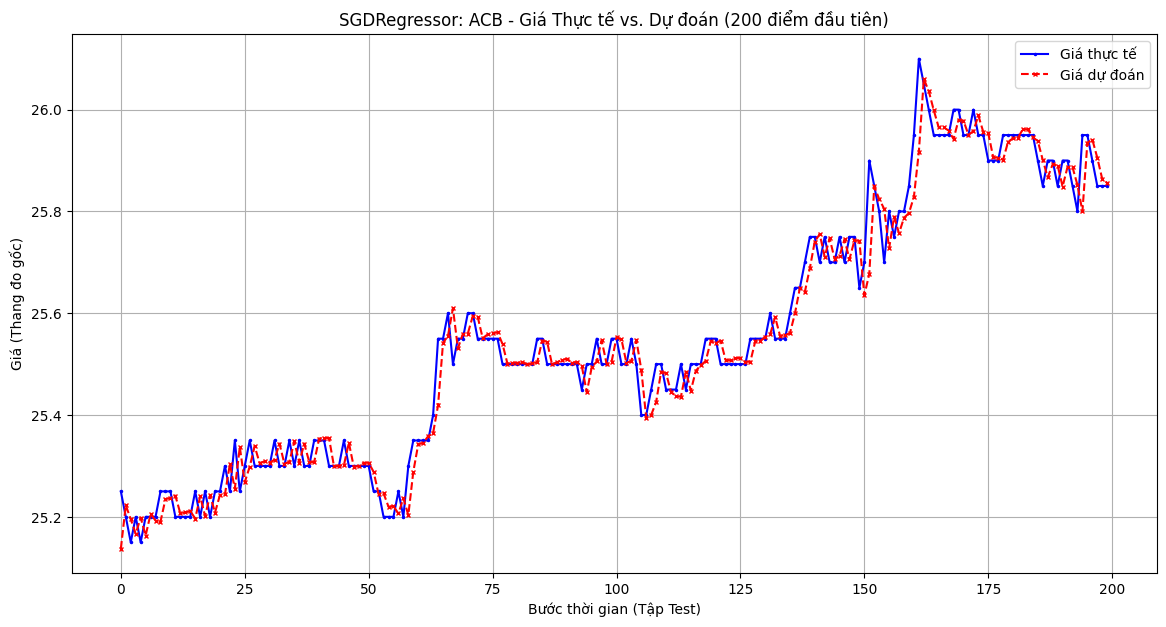


Đang đánh giá cho mã: BID
[BID] Số lượng điểm test (targets): 1595
Kết quả Đánh giá SGDRegressor cho [BID] (Thang đo gốc): R2=0.9877, MSE=0.0043, MAE=0.0424


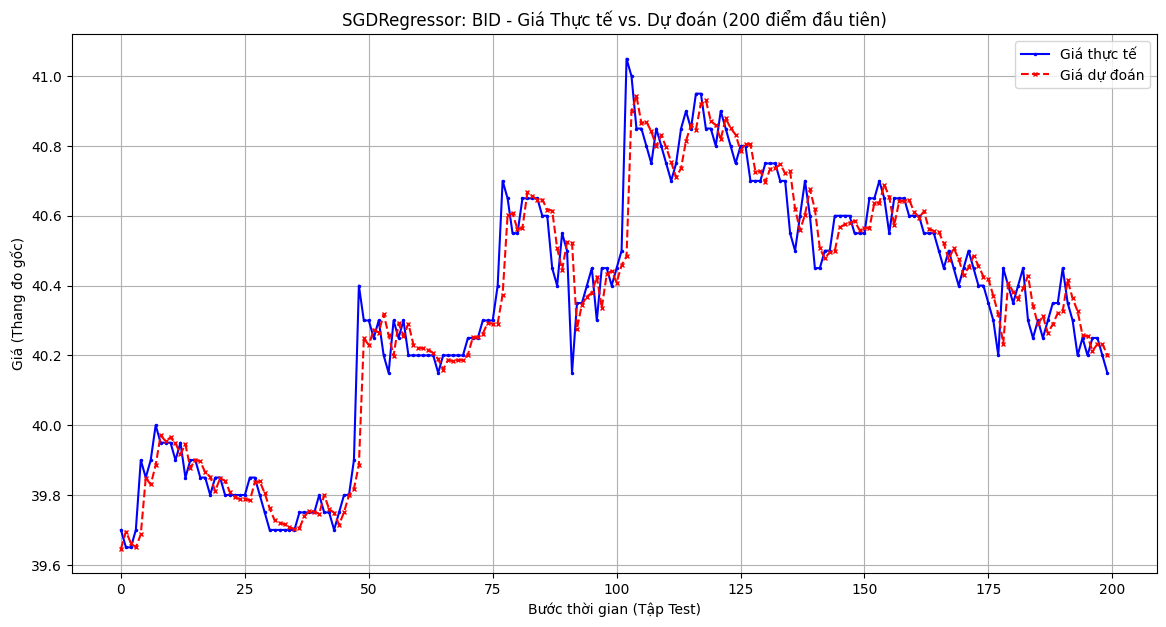


Đang đánh giá cho mã: CTG
[CTG] Số lượng điểm test (targets): 1682
Kết quả Đánh giá SGDRegressor cho [CTG] (Thang đo gốc): R2=0.9892, MSE=0.0065, MAE=0.0551


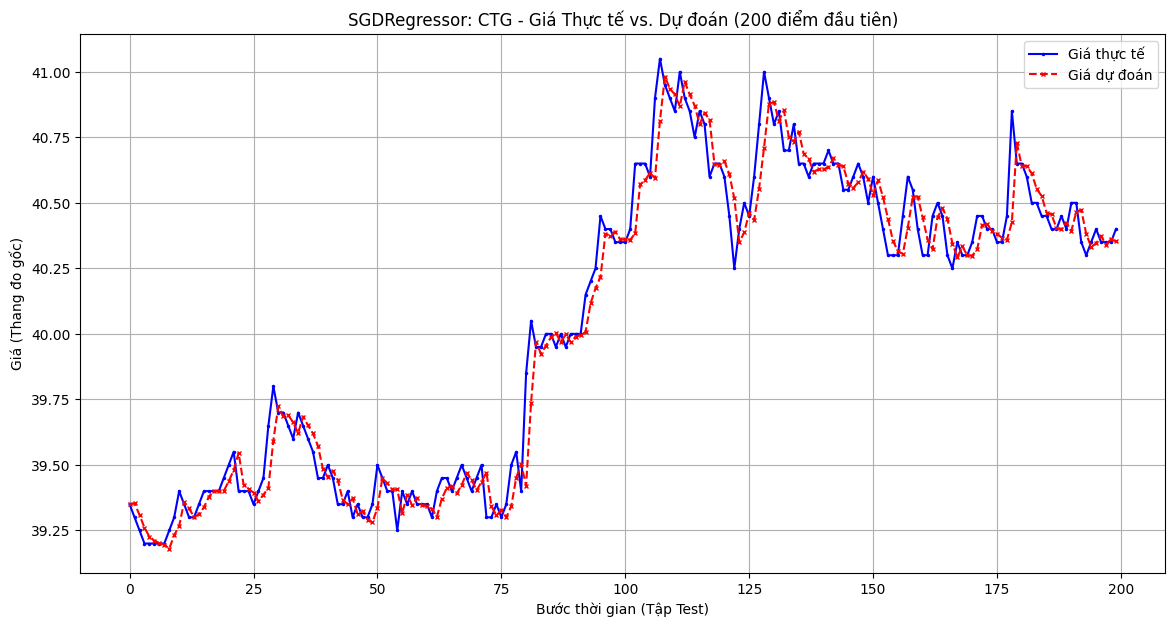


Đang đánh giá cho mã: HDB
[HDB] Số lượng điểm test (targets): 1609
Kết quả Đánh giá SGDRegressor cho [HDB] (Thang đo gốc): R2=0.9804, MSE=0.0022, MAE=0.0326


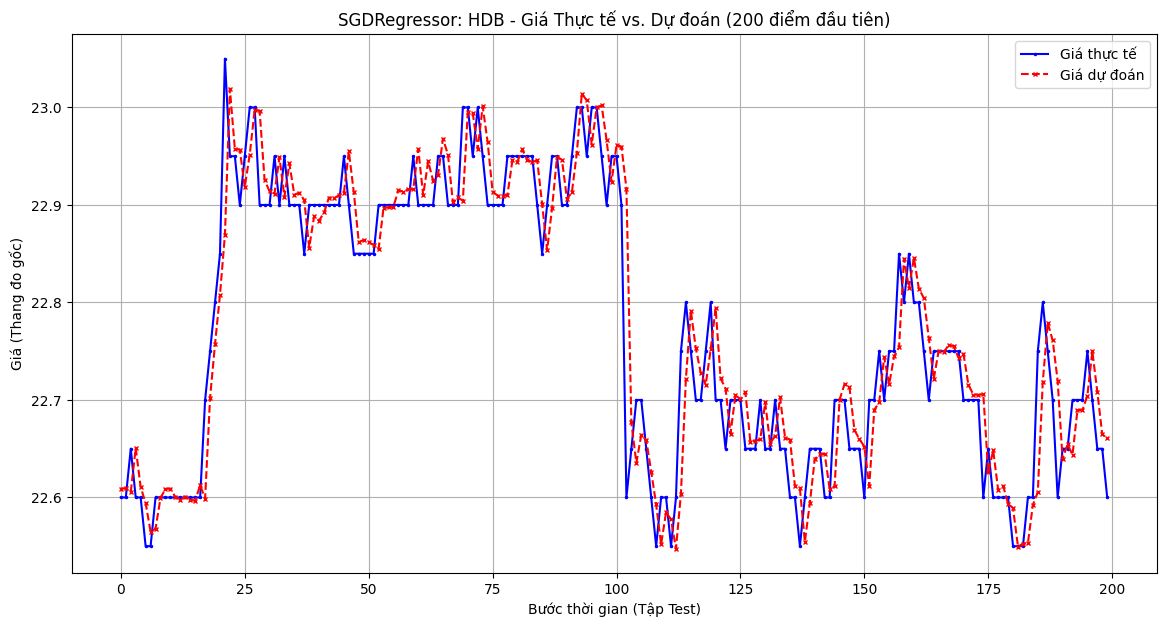


Đang đánh giá cho mã: LPB
[LPB] Số lượng điểm test (targets): 1451
Kết quả Đánh giá SGDRegressor cho [LPB] (Thang đo gốc): R2=0.9950, MSE=0.0075, MAE=0.0595


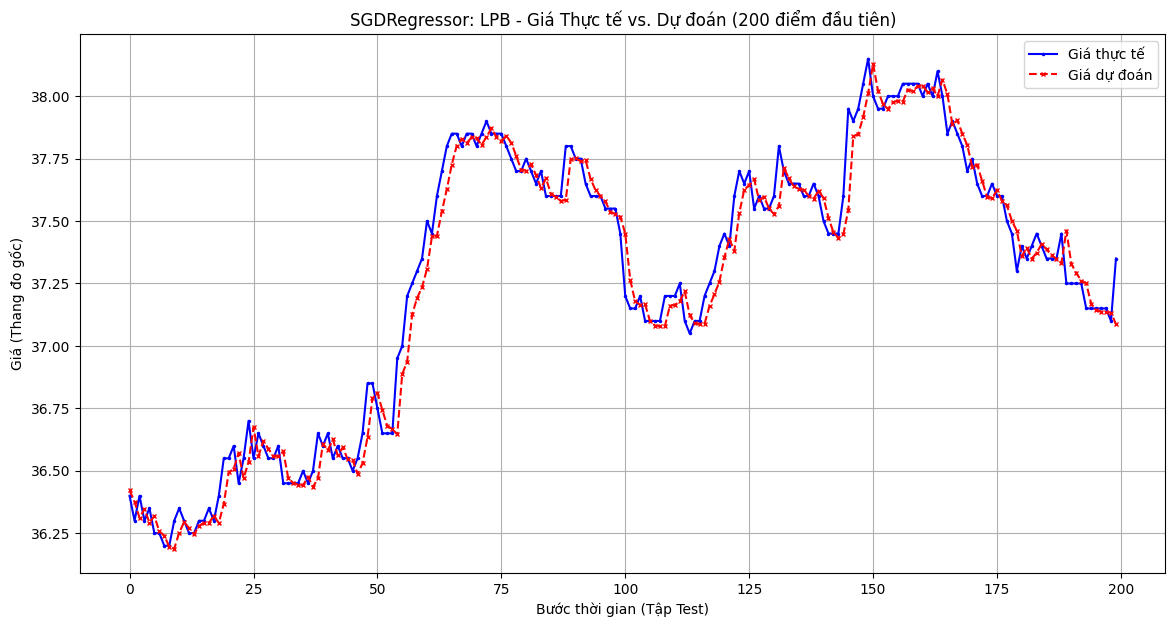


Đang đánh giá cho mã: MBB
[MBB] Số lượng điểm test (targets): 1701
Kết quả Đánh giá SGDRegressor cho [MBB] (Thang đo gốc): R2=0.9951, MSE=0.0025, MAE=0.0339


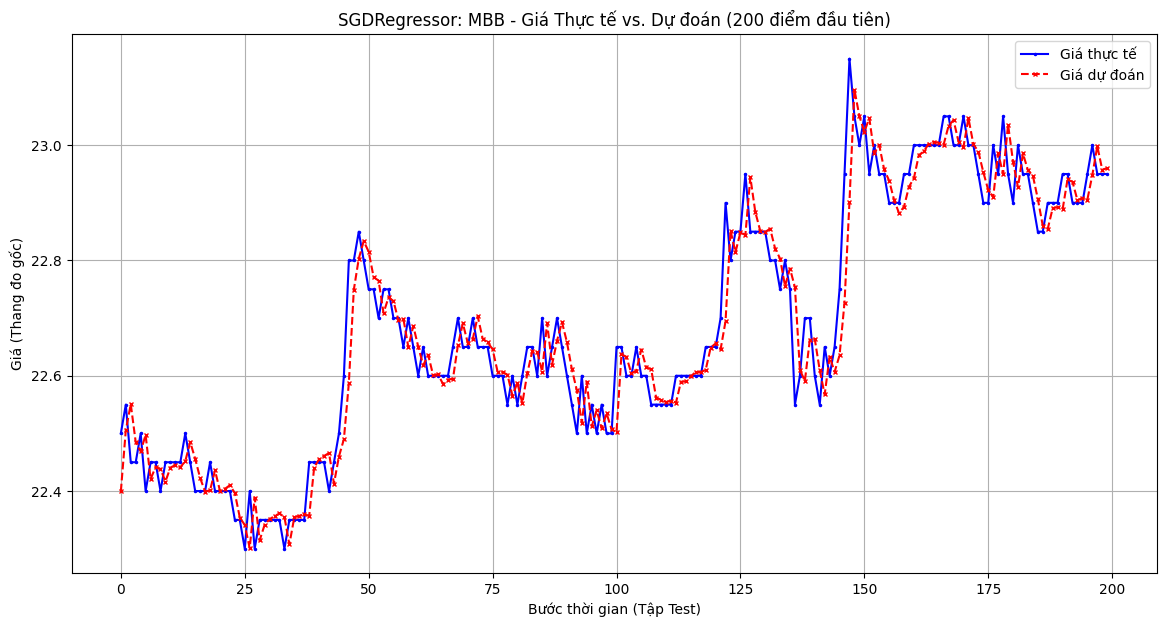


Đang đánh giá cho mã: SHB
[SHB] Số lượng điểm test (targets): 1656
Kết quả Đánh giá SGDRegressor cho [SHB] (Thang đo gốc): R2=0.9981, MSE=0.0017, MAE=0.0279


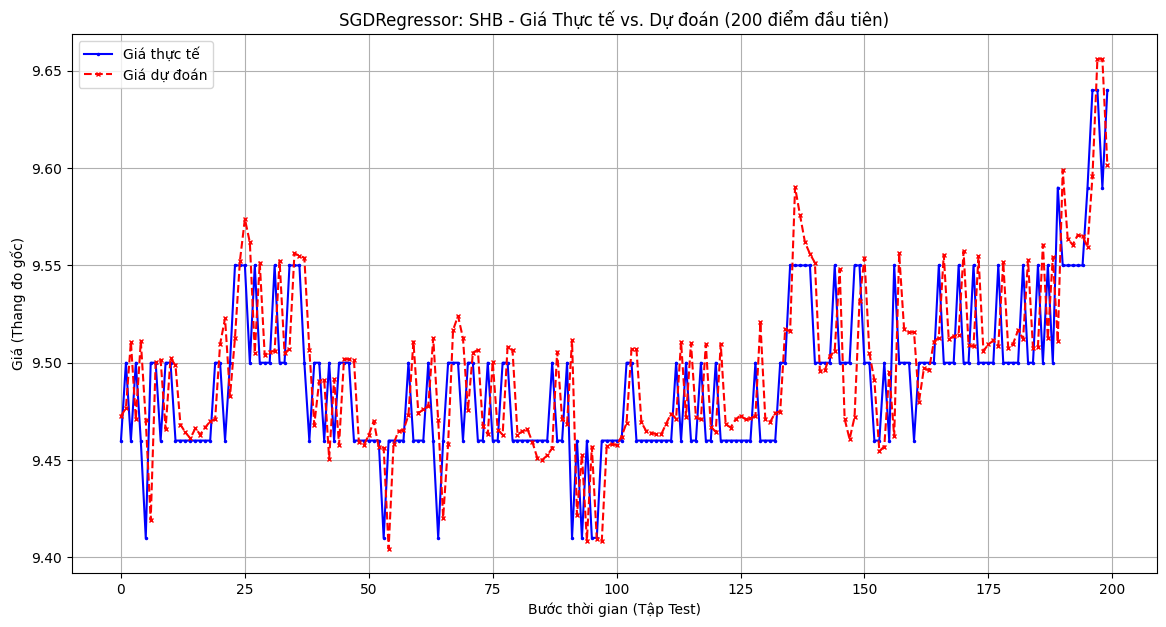


Đang đánh giá cho mã: STB
[STB] Số lượng điểm test (targets): 1693
Kết quả Đánh giá SGDRegressor cho [STB] (Thang đo gốc): R2=0.9821, MSE=0.0069, MAE=0.0544


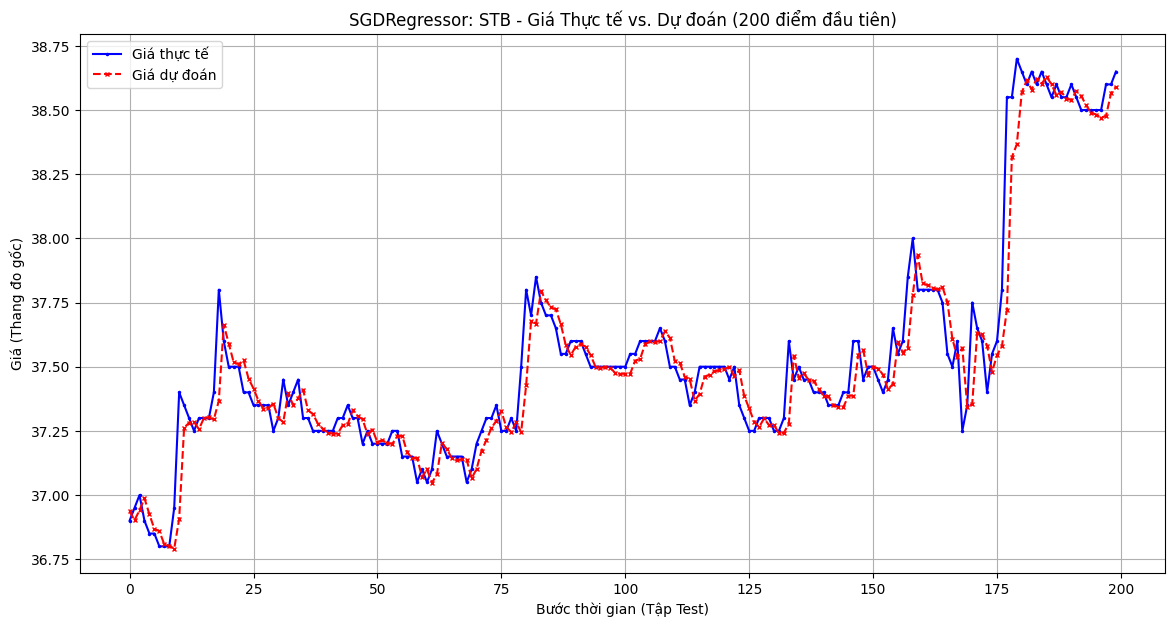


Đang đánh giá cho mã: TCB
[TCB] Số lượng điểm test (targets): 1688
Kết quả Đánh giá SGDRegressor cho [TCB] (Thang đo gốc): R2=0.9958, MSE=0.0034, MAE=0.0381


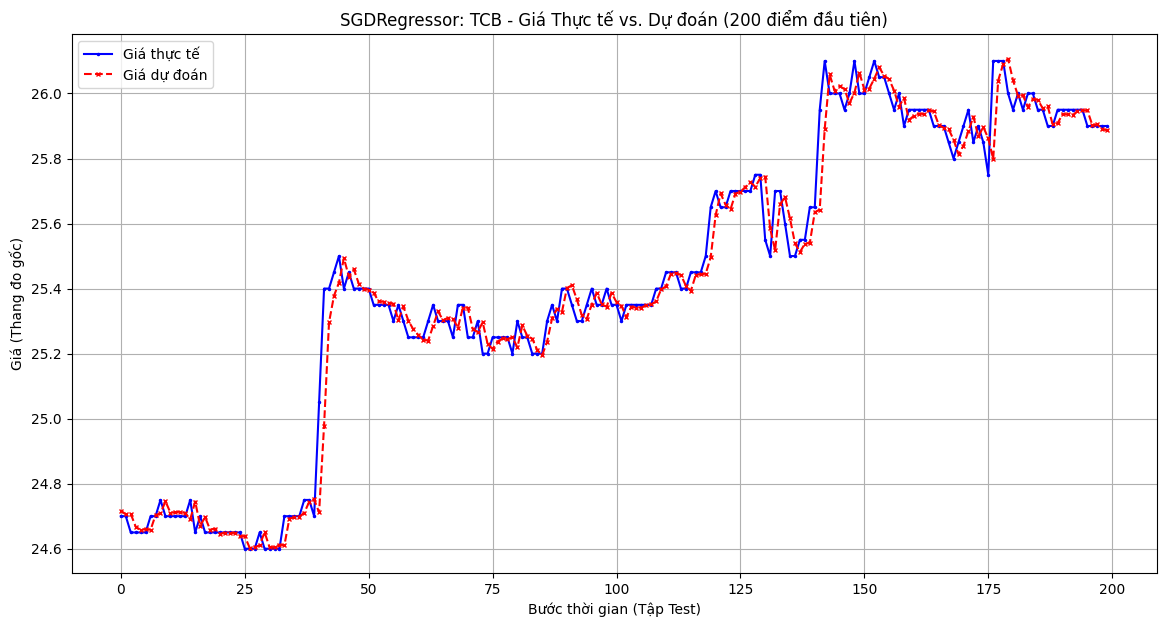


Đang đánh giá cho mã: TPB
[TPB] Số lượng điểm test (targets): 1642
Kết quả Đánh giá SGDRegressor cho [TPB] (Thang đo gốc): R2=0.9971, MSE=0.0020, MAE=0.0303


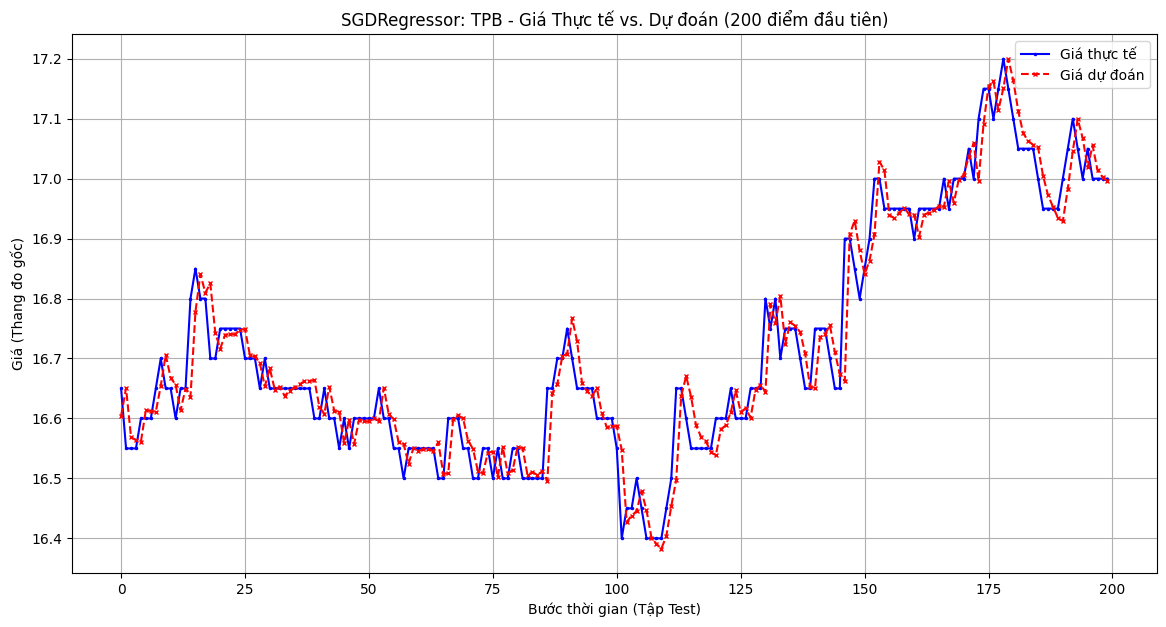


Đang đánh giá cho mã: VCB
[VCB] Số lượng điểm test (targets): 1599
Kết quả Đánh giá SGDRegressor cho [VCB] (Thang đo gốc): R2=0.9967, MSE=0.0154, MAE=0.0673


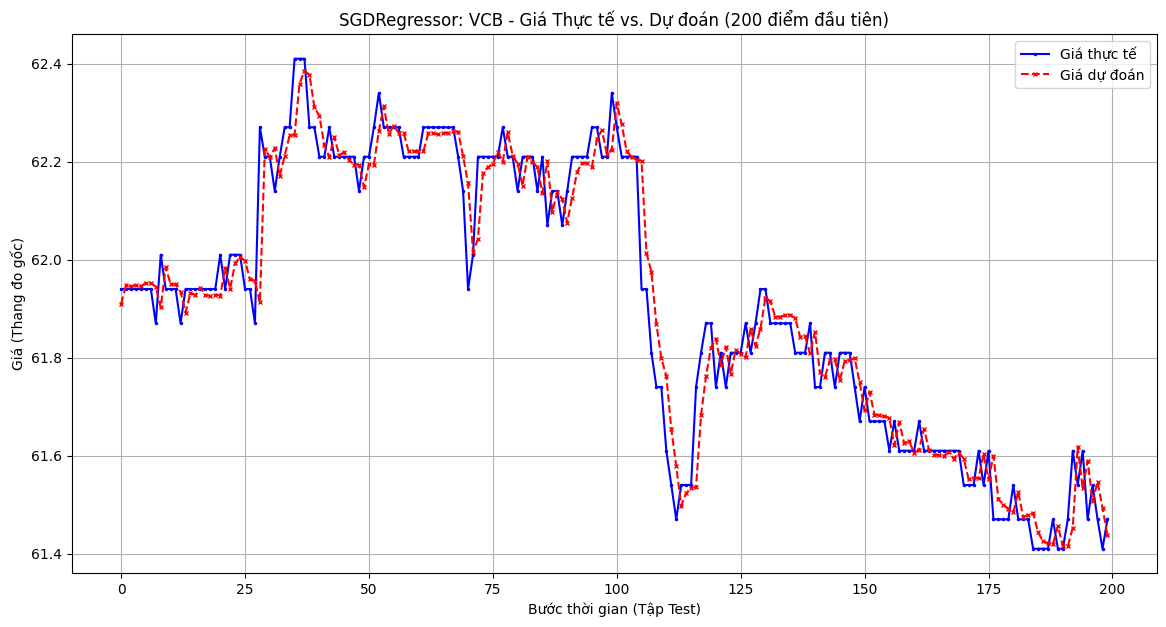


Đang đánh giá cho mã: VIB
[VIB] Số lượng điểm test (targets): 1552
Kết quả Đánh giá SGDRegressor cho [VIB] (Thang đo gốc): R2=0.9757, MSE=0.0022, MAE=0.0321


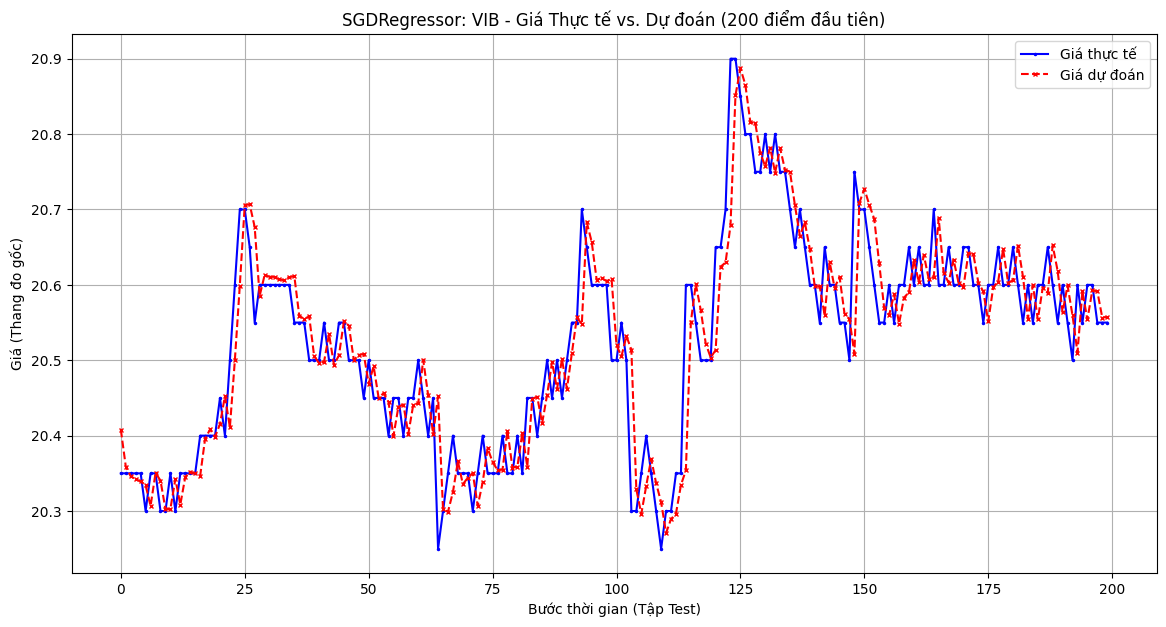


--- Đánh giá SGD Tổng thể (Overall) ---
Tổng số điểm đánh giá overall: 19522
Kết quả Đánh giá SGDRegressor cho [Overall] (Thang đo gốc): R2=1.0000, MSE=0.0047, MAE=0.0419


In [9]:
#   10 test và Đánh giá 
if os.path.exists(sgd_model_path) and scaled_encoded_test_data:
    print(f"\nĐang tải mô hình SGDRegressor từ: {sgd_model_path}...")
    sgd_model_loaded = joblib.load(sgd_model_path)
    print("Bắt đầu đánh giá SGDRegressor...")

    all_y_true_sgd = []
    all_y_pred_sgd = []
    sgd_test_batch_size = 2048

    print("\n--- Đánh giá SGD trên từng công ty ---")
    available_test_symbols = [s for s in STOCK_LIST if s in scaled_encoded_test_data and not scaled_encoded_test_data[s].empty]
    for symbol in available_test_symbols:
        print(f"\nĐang đánh giá cho mã: {symbol}")
        temp_test_dict = {symbol: scaled_encoded_test_data[symbol]}

        sgd_test_generator_single = StockDataSequenceFlattened(
            data_dict=temp_test_dict, window_size=WINDOW_SIZE, horizon=HORIZON,
            batch_size=sgd_test_batch_size, target_col_name=TARGET_COL_NAME,
            feature_list=sequence_feature_names, shuffle=False
        )

        if len(sgd_test_generator_single) == 0:
            print(f"[{symbol}] Không tạo được batch nào từ generator test. Bỏ qua.")
            continue

        y_test_true_scaled_single = sgd_test_generator_single.get_all_targets()
        if y_test_true_scaled_single.size == 0:
             print(f"[{symbol}] Không lấy được giá trị target nào từ generator. Bỏ qua.")
             continue
        print(f"[{symbol}] Số lượng điểm test (targets): {len(y_test_true_scaled_single)}")

        y_pred_sgd_scaled_single_list = []
        # print(f"[{symbol}] Đang dự đoán...") # Optional
        for i in range(len(sgd_test_generator_single)):
             X_batch_flat, _ = sgd_test_generator_single[i]
             if X_batch_flat.shape[0] > 0:
                 y_pred_batch = sgd_model_loaded.predict(X_batch_flat)
                 y_pred_sgd_scaled_single_list.append(y_pred_batch)

        if not y_pred_sgd_scaled_single_list:
            print(f"[{symbol}] Không tạo được dự đoán nào. Bỏ qua.")
            continue

        y_pred_sgd_scaled_single = np.concatenate(y_pred_sgd_scaled_single_list)
        y_true_inv_single = data_processor.inverse_transform_target(y_test_true_scaled_single)
        y_pred_inv_single = data_processor.inverse_transform_target(y_pred_sgd_scaled_single)

        # Đánh giá và lưu kết quả
        metrics = evaluate_model(y_true_inv_single, y_pred_inv_single, "SGDRegressor", symbol)
        sgd_results_per_stock[symbol] = {'metrics': metrics, 'y_true': y_true_inv_single, 'y_pred': y_pred_inv_single}

        # Vẽ biểu đồ so sánh cuối cùng
        plot_predictions(y_true_inv_single, y_pred_inv_single, f'SGDRegressor: {symbol} - Giá Thực tế vs. Dự đoán')

        all_y_true_sgd.extend(y_true_inv_single)
        all_y_pred_sgd.extend(y_pred_inv_single)

    # **Đánh giá tổng thể (Overall)**
    print("\n--- Đánh giá SGD Tổng thể (Overall) ---")
    if all_y_true_sgd and all_y_pred_sgd:
        print(f"Tổng số điểm đánh giá overall: {len(all_y_true_sgd)}")
        overall_metrics_sgd = evaluate_model(np.array(all_y_true_sgd), np.array(all_y_pred_sgd), "SGDRegressor", "Overall")
    else:
        print("Không có đủ dữ liệu để đánh giá tổng thể cho SGD.")

elif not os.path.exists(sgd_model_path):
    print("\nBỏ qua kiểm thử/đánh giá SGD: Không tìm thấy file mô hình.")
else: 
    print("\nBỏ qua kiểm thử/đánh giá SGD: Dữ liệu test chưa được xử lý hoặc trống.")